Try to run the custom model, bearing in mind this notebook is running in a docker container

* interpreter installer -> https://www.tensorflow.org/lite/guide/python
* example code using model -> https://github.com/tensorflow/examples/blob/master/lite/examples/image_classification/raspberry_pi/classify_picamera.py
* Hit this error, just had to rerun the notebook -> https://stackoverflow.com/questions/56777704/how-to-fix-there-is-at-least-1-reference-to-internal-data-in-the-interpreter-in

In [1]:
!uname

Linux


In [2]:
!uname --m

x86_64


Install the tflite interpreter for x86 linux

In [3]:
!pip install https://dl.google.com/coral/python/tflite_runtime-2.1.0.post1-cp37-cp37m-linux_x86_64.whl

In [4]:
import io
import logging
import sys

import numpy as np
import tflite_runtime.interpreter as tflite
from PIL import Image

In [5]:
MODEL_FOLDER = "/home/jovyan/work/Tensorflow/teachable-machine-custom-model/dogs-vs-cats/"
MODEL_FILE = MODEL_FOLDER + "model.tflite"
LABEL_FILE = MODEL_FOLDER + "labels.txt"

First read the labels

In [6]:
LABEL_FILE

'/home/jovyan/work/Tensorflow/teachable-machine-custom-model/dogs-vs-cats/labels.txt'

In [7]:
def read_labels(file_path):
    """
    Helper for loading coco_labels.txt
    """
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
        ret = {}
        for line in lines:
            pair = line.strip().split(maxsplit=1)
            ret[int(pair[0])] = pair[1].strip()
    return ret

In [8]:
labels = read_labels(LABEL_FILE)
labels

{0: 'dog', 1: 'cat'}

Load the model

In [9]:
interpreter = tflite.Interpreter(model_path=MODEL_FILE)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_height = input_details[0]["shape"][1]
input_width = input_details[0]["shape"][2]

In [10]:
print(input_height)
print(input_width)

224
224


In [11]:
ls

cats-vs-dogs.ipynb  untrained-cat.100.jpg  untrained-dog.11622.jpg
dogs-vs-cats/       untrained-cat.186.jpg  untrained-dog.11873.jpg
README.md           untrained-cat.284.jpg  untrained-dog.11884.jpg


Get test images and resize

In [12]:
cat_img_1 = Image.open('untrained-cat.100.jpg').resize((input_width, input_height), Image.ANTIALIAS)
dog_img_1 = Image.open('untrained-dog.11622.jpg').resize((input_width, input_height), Image.ANTIALIAS)
cat_img_2 = Image.open('untrained-cat.186.jpg').resize((input_width, input_height), Image.ANTIALIAS)
dog_img_2 = Image.open('untrained-dog.11873.jpg').resize((input_width, input_height), Image.ANTIALIAS)
cat_img_3 = Image.open('untrained-cat.284.jpg').resize((input_width, input_height), Image.ANTIALIAS)
dog_img_3 = Image.open('untrained-dog.11884.jpg').resize((input_width, input_height), Image.ANTIALIAS)

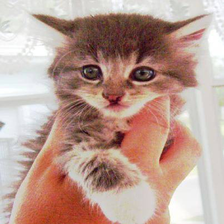

In [13]:
cat_img_1

In [14]:
def set_input_tensor(interpreter, image):
    tensor_index = interpreter.get_input_details()[0]['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

def classify_image(interpreter, image, top_k=1):
    """Returns a sorted array of classification results."""
    set_input_tensor(interpreter, image)
    interpreter.invoke()
    output_details = interpreter.get_output_details()[0]
    output = np.squeeze(interpreter.get_tensor(output_details['index']))

    # If the model is quantized (uint8 data), then dequantize the results
    if output_details['dtype'] == np.uint8:
        scale, zero_point = output_details['quantization']
        output = scale * (output - zero_point)

    ordered = np.argpartition(-output, top_k)
    return [(i, output[i]) for i in ordered[:top_k]]

## Test cats

In [15]:
results = classify_image(interpreter, image=cat_img_1)
label_id, prob = results[0]
print(f"{labels[label_id]}, {prob}")

cat, 0.99609375


In [16]:
results = classify_image(interpreter, image=cat_img_2)
label_id, prob = results[0]
print(f"{labels[label_id]}, {prob}")

cat, 0.99609375


In [17]:
results = classify_image(interpreter, image=cat_img_3)
label_id, prob = results[0]
print(f"{labels[label_id]}, {prob}")

cat, 0.99609375


## Test dogs

In [18]:
results = classify_image(interpreter, image=dog_img_1)
label_id, prob = results[0]
print(f"{labels[label_id]}, {prob}")

cat, 0.99609375


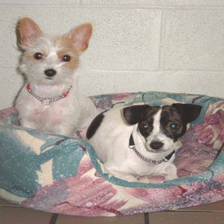

In [19]:
# error for this image
dog_img_1

In [20]:
results = classify_image(interpreter, image=dog_img_2)
label_id, prob = results[0]
print(f"{labels[label_id]}, {prob}")

dog, 0.99609375


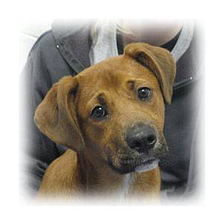

In [21]:
dog_img_2

In [22]:
results = classify_image(interpreter, image=dog_img_3)
label_id, prob = results[0]
print(f"{labels[label_id]}, {prob}")

dog, 0.99609375


## Summary
Pretty easy to use, just one issue encountered that was solved by restarting the notebook.
Model made an error on the dog image, but this model was only trained in 60 images and is quantized